###Imports

In [ ]:
import h5py
import keras
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

###Data Loader

In [ ]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data

In [ ]:
cl_x_valid, cl_y_valid = data_loader('./data/cl/valid.h5')
cl_x_test, cl_y_test = data_loader('./data/cl/test.h5')
bd_x_valid, bd_y_valid = data_loader('./data/bd/bd_valid.h5')
bd_x_test, bd_y_test = data_loader('./data/bd/bd_test.h5')
N = int(cl_y_test.max())

print(f"Number of classes: {N}")

Number of classes: 1282


###Sample Data

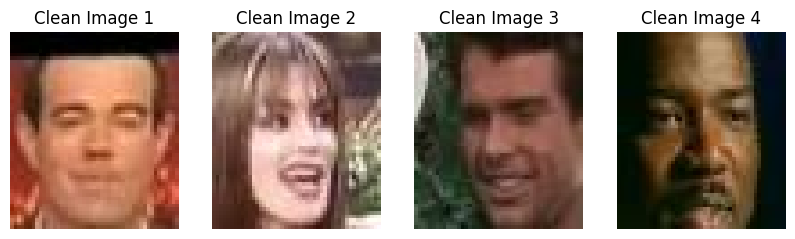

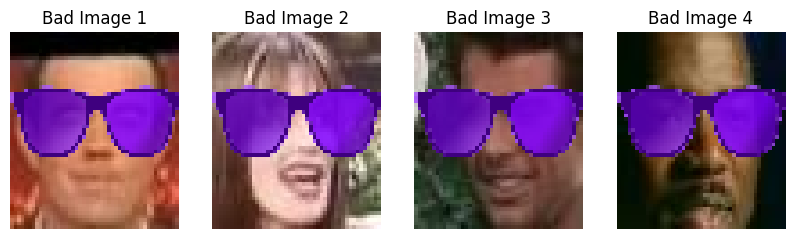

In [ ]:
plt.figure(figsize=(10,5))
indexes = []
for i in range(4):
    index = np.random.randint(cl_x_valid.shape[0], size=1)[0]
    indexes.append(index)
    plt.subplot(1,4,i+1)
    plt.axis('off')
    plt.title(f"Clean Image {i+1}")
    plt.imshow(cl_x_valid[index].astype(np.uint8))

plt.show()


plt.figure(figsize=(10,5))
for i in range(4):
    index = indexes[i]
    plt.subplot(1,4,i+1)
    plt.axis('off')
    plt.title(f"Bad Image {i+1}")
    plt.imshow(bd_x_valid[index].astype(np.uint8))

plt.show()

###Model Accuracy

In [ ]:
bd_model = keras.models.load_model('./models/bd_net.h5')

def evalModel(model):
    cl_labels = np.argmax(model.predict(cl_x_test), axis=1)
    accuracy = np.mean(np.equal(cl_labels, cl_y_test))*100

    bd_labels = np.argmax(model.predict(bd_x_test), axis=1)
    success_rate = np.mean(np.equal(bd_labels, bd_y_test))*100
    return accuracy, success_rate

accuracy, success_rate = evalModel(bd_model)
print('Clean Classification accuracy:', accuracy)
print('Attack Success Rate:', success_rate)

401/401 [==============================] - 1s 3ms/step
Clean Classification accuracy: 98.62042088854248
Attack Success Rate: 100.0


###Model Summary

In [ ]:
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

###Repairing Model

In [ ]:
def calculateAccuracy(pred_model, pred_model2, Y):
    preds = []
    for i in range(len(pred_model)):
        if pred_model[i] == pred_model2[i]:
            preds.append(pred_model2[i])
        else:
            preds.append(N + 1)
    preds = np.array(preds)

    accuracy = np.mean(np.equal(preds, Y))*100
    return accuracy

In [ ]:
def calAccSucRate_test(bd_model2, cl_pred_test, bd_pred_test):
    #Accuracy
    cl_pred_test_model2 = np.argmax(bd_model2.predict(cl_x_test), axis=1)
    accuracy_model2 = calculateAccuracy(cl_pred_test, cl_pred_test_model2, cl_y_test)

    #Success Rate
    bd_pred_test_model2 = np.argmax(bd_model2.predict(bd_x_test), axis=1)
    success_rate_model2 = calculateAccuracy(bd_pred_test, bd_pred_test_model2, bd_y_test)

    return accuracy_model2, success_rate_model2

In [ ]:
def repair_model():
    Xs = [2, 4, 10]
    is_model_saved = {}
    for X in Xs:
      is_model_saved[X] = 0

    acc_clean_datas = []
    success_rates = []


    #prediction on clean data
    print("Prediction on Clean Data:")
    cl_pred = np.argmax(bd_model.predict(cl_x_valid), axis=1)
    cl_pred_test = np.argmax(bd_model.predict(cl_x_test), axis=1)

    #prediction on bad data
    print("\nPrediction on Bad Data:")
    bd_pred = np.argmax(bd_model.predict(bd_x_valid), axis=1)
    bd_pred_test = np.argmax(bd_model.predict(bd_x_test), axis=1)


    bd_model2 = keras.models.clone_model(bd_model)
    bd_model2.set_weights(bd_model.get_weights())

    # we need to drop one channel in conv_3 each time
    conv_3 = bd_model2.get_layer('conv_3')

    intermediate = keras.Model(inputs=bd_model2.input, outputs=conv_3.output)

    print("\nObtaining channels:")
    activation_values = intermediate.predict(cl_x_valid).sum(axis=(0, 1, 2))
    ordered_channels = np.argsort(activation_values)
    print()

    # delete channels in order
    for channel in tqdm(ordered_channels):
        conv_3_mod = np.array(conv_3.get_weights()[0])
        conv_3_mod[:, :, :, channel] = np.zeros((3, 3, 40))
        conv_3.set_weights(list([conv_3_mod, conv_3.get_weights()[1]]))

        cl_pred_model2 = np.argmax(bd_model2.predict(cl_x_valid), axis=1)

        #validation accuracy of pruned model
        valid_accuracy_model2 = calculateAccuracy(cl_pred, cl_pred_model2, cl_y_valid)

        #test accuracy of pruned model
        accuracy_model2, success_rate_model2 = calAccSucRate_test(bd_model2, cl_pred_test, bd_pred_test)

        for X in Xs:
            if (accuracy - valid_accuracy_model2) >= X and not(is_model_saved[X]):
                print(f"\n\nDrop: {X}, Accuracy: {accuracy_model2}, Success Rate: {success_rate_model2}\n\n")
                is_model_saved[X] = 1
                bd_model2.save(f"./models/bd_model2_X{X}.h5")
                break

        print("Pruned Channel Index:", channel)
        print("Test Accuracy:", accuracy_model2)
        print("Attack Success Rate:", success_rate_model2)
        print()

        acc_clean_datas.append(accuracy_model2)
        success_rates.append(success_rate_model2)

        keras.backend.clear_session()

    return acc_clean_datas, success_rates

In [ ]:
acc_clean_datas, success_rates = repair_model()

Prediction on Clean Data:
401/401 [==============================] - 1s 2ms/step

Prediction on Bad Data:
401/401 [==============================] - 1s 2ms/step

Obtaining channels:
361/361 [==============================] - 2s 2ms/step



  0%|          | 0/60 [00:00<?, ?it/s]

401/401 [==============================] - 1s 2ms/step


  2%|▏         | 1/60 [00:04<04:06,  4.18s/it]

Pruned Channel Index: 0
Test Accuracy: 98.62042088854248
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


  3%|▎         | 2/60 [00:08<04:07,  4.27s/it]

Pruned Channel Index: 26
Test Accuracy: 98.62042088854248
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


  5%|▌         | 3/60 [00:12<04:04,  4.29s/it]

Pruned Channel Index: 27
Test Accuracy: 98.62042088854248
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


  7%|▋         | 4/60 [00:16<03:56,  4.22s/it]

Pruned Channel Index: 30
Test Accuracy: 98.62042088854248
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


  8%|▊         | 5/60 [00:21<03:50,  4.18s/it]

Pruned Channel Index: 31
Test Accuracy: 98.62042088854248
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


 10%|█         | 6/60 [00:25<03:48,  4.24s/it]

Pruned Channel Index: 33
Test Accuracy: 98.62042088854248
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


 12%|█▏        | 7/60 [00:29<03:47,  4.28s/it]

Pruned Channel Index: 34
Test Accuracy: 98.62042088854248
Attack Success Rate: 100.0

401/401 [==============================] - 1s 3ms/step


 13%|█▎        | 8/60 [00:34<03:47,  4.37s/it]

Pruned Channel Index: 36
Test Accuracy: 98.62042088854248
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


 15%|█▌        | 9/60 [00:38<03:47,  4.45s/it]

Pruned Channel Index: 37
Test Accuracy: 98.62042088854248
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


 17%|█▋        | 10/60 [00:45<04:13,  5.07s/it]

Pruned Channel Index: 38
Test Accuracy: 98.62042088854248
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


 18%|█▊        | 11/60 [00:50<04:06,  5.02s/it]

Pruned Channel Index: 25
Test Accuracy: 98.62042088854248
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


 20%|██        | 12/60 [00:56<04:21,  5.44s/it]

Pruned Channel Index: 39
Test Accuracy: 98.62042088854248
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step
Pruned Channel Index: 41
Test Accuracy: 98.62042088854248
Attack Success Rate: 100.0



 22%|██▏       | 13/60 [01:02<04:23,  5.60s/it]

401/401 [==============================] - 1s 2ms/step


 23%|██▎       | 14/60 [01:07<04:11,  5.47s/it]

Pruned Channel Index: 44
Test Accuracy: 98.62042088854248
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step
Pruned Channel Index: 45
Test Accuracy: 98.62042088854248
Attack Success Rate: 100.0



 25%|██▌       | 15/60 [01:14<04:16,  5.71s/it]

401/401 [==============================] - 1s 2ms/step


 27%|██▋       | 16/60 [01:19<04:12,  5.74s/it]

Pruned Channel Index: 47
Test Accuracy: 98.62042088854248
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


 28%|██▊       | 17/60 [01:24<03:52,  5.40s/it]

Pruned Channel Index: 48
Test Accuracy: 98.62042088854248
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


 30%|███       | 18/60 [01:28<03:32,  5.05s/it]

Pruned Channel Index: 49
Test Accuracy: 98.62042088854248
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


 32%|███▏      | 19/60 [01:33<03:19,  4.87s/it]

Pruned Channel Index: 50
Test Accuracy: 98.62042088854248
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


 33%|███▎      | 20/60 [01:46<04:51,  7.29s/it]

Pruned Channel Index: 53
Test Accuracy: 98.62042088854248
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


 35%|███▌      | 21/60 [01:50<04:06,  6.33s/it]

Pruned Channel Index: 55
Test Accuracy: 98.62042088854248
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


 37%|███▋      | 22/60 [01:54<03:35,  5.66s/it]

Pruned Channel Index: 40
Test Accuracy: 98.62042088854248
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


 38%|███▊      | 23/60 [01:58<03:10,  5.15s/it]

Pruned Channel Index: 24
Test Accuracy: 98.62042088854248
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


 40%|████      | 24/60 [02:02<02:53,  4.81s/it]

Pruned Channel Index: 59
Test Accuracy: 98.62042088854248
Attack Success Rate: 100.0

401/401 [==============================] - 1s 3ms/step


 42%|████▏     | 25/60 [02:06<02:44,  4.71s/it]

Pruned Channel Index: 9
Test Accuracy: 98.61262665627436
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


 43%|████▎     | 26/60 [02:10<02:34,  4.54s/it]

Pruned Channel Index: 2
Test Accuracy: 98.61262665627436
Attack Success Rate: 100.0

401/401 [==============================] - 1s 3ms/step
Pruned Channel Index: 12
Test Accuracy: 98.61262665627436
Attack Success Rate: 100.0



 45%|████▌     | 27/60 [02:15<02:29,  4.54s/it]

401/401 [==============================] - 1s 2ms/step


 47%|████▋     | 28/60 [02:19<02:23,  4.49s/it]

Pruned Channel Index: 13
Test Accuracy: 98.61262665627436
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


 48%|████▊     | 29/60 [02:24<02:16,  4.40s/it]

Pruned Channel Index: 17
Test Accuracy: 98.61262665627436
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


 50%|█████     | 30/60 [02:28<02:10,  4.36s/it]

Pruned Channel Index: 14
Test Accuracy: 98.61262665627436
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


 52%|█████▏    | 31/60 [02:32<02:05,  4.32s/it]

Pruned Channel Index: 15
Test Accuracy: 98.61262665627436
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


 53%|█████▎    | 32/60 [02:36<02:00,  4.29s/it]

Pruned Channel Index: 23
Test Accuracy: 98.61262665627436
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step
Pruned Channel Index: 6
Test Accuracy: 98.61262665627436
Attack Success Rate: 100.0



 55%|█████▌    | 33/60 [02:41<01:55,  4.28s/it]

401/401 [==============================] - 1s 2ms/step


 57%|█████▋    | 34/60 [02:45<01:50,  4.25s/it]

Pruned Channel Index: 51
Test Accuracy: 98.60483242400623
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


 58%|█████▊    | 35/60 [02:49<01:46,  4.26s/it]

Pruned Channel Index: 32
Test Accuracy: 98.59703819173812
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


 60%|██████    | 36/60 [02:53<01:41,  4.22s/it]

Pruned Channel Index: 22
Test Accuracy: 98.58924395947
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


 62%|██████▏   | 37/60 [02:57<01:37,  4.22s/it]

Pruned Channel Index: 21
Test Accuracy: 98.58144972720187
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step
Pruned Channel Index: 20
Test Accuracy: 98.57365549493376
Attack Success Rate: 100.0



 63%|██████▎   | 38/60 [03:02<01:32,  4.22s/it]

401/401 [==============================] - 1s 2ms/step


 65%|██████▌   | 39/60 [03:06<01:28,  4.22s/it]

Pruned Channel Index: 19
Test Accuracy: 98.54247856586126
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


 67%|██████▋   | 40/60 [03:10<01:24,  4.22s/it]

Pruned Channel Index: 43
Test Accuracy: 98.45674201091192
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


 68%|██████▊   | 41/60 [03:15<01:25,  4.52s/it]

Pruned Channel Index: 3
Test Accuracy: 98.15276695245518
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


 70%|███████   | 42/60 [03:21<01:28,  4.91s/it]

Pruned Channel Index: 58
Test Accuracy: 98.0826188620421
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


 72%|███████▏  | 43/60 [03:34<02:03,  7.26s/it]

Pruned Channel Index: 42
Test Accuracy: 97.71628994544037
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step
Pruned Channel Index: 1
Test Accuracy: 97.54481683554171
Attack Success Rate: 100.0



 73%|███████▎  | 44/60 [03:40<01:52,  7.04s/it]

401/401 [==============================] - 1s 2ms/step


Accuracy Drop: 2, Accuracy: 95.8846453624318, Success Rate: 100.0




/home/rusherrg/anaconda3/envs/dl/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
 75%|███████▌  | 45/60 [03:47<01:44,  6.98s/it]

Pruned Channel Index: 29
Test Accuracy: 95.8846453624318
Attack Success Rate: 100.0

401/401 [==============================] - 1s 2ms/step


 77%|███████▋  | 46/60 [03:52<01:26,  6.21s/it]

Pruned Channel Index: 16
Test Accuracy: 95.47155105222136
Attack Success Rate: 99.97661730319564

401/401 [==============================] - 1s 3ms/step


 78%|███████▊  | 47/60 [03:58<01:20,  6.17s/it]

Pruned Channel Index: 5
Test Accuracy: 95.14419329696024
Attack Success Rate: 99.97661730319564

401/401 [==============================] - 1s 3ms/step


Accuracy Drop: 4, Accuracy: 94.61418550272798, Success Rate: 99.97661730319564




 80%|████████  | 48/60 [04:02<01:07,  5.65s/it]

Pruned Channel Index: 56
Test Accuracy: 94.61418550272798
Attack Success Rate: 99.97661730319564

401/401 [==============================] - 2s 6ms/step


 82%|████████▏ | 49/60 [04:11<01:13,  6.67s/it]

Pruned Channel Index: 8
Test Accuracy: 94.13873733437256
Attack Success Rate: 99.97661730319564

401/401 [==============================] - 1s 2ms/step


 83%|████████▎ | 50/60 [04:17<01:03,  6.32s/it]

Pruned Channel Index: 11
Test Accuracy: 92.34606391270461
Attack Success Rate: 79.69602494154326

401/401 [==============================] - 1s 3ms/step


 85%|████████▌ | 51/60 [04:25<01:03,  7.03s/it]

Pruned Channel Index: 46
Test Accuracy: 89.65705378020265
Attack Success Rate: 79.68823070927513

401/401 [==============================] - 1s 3ms/step


Accuracy Drop: 10, Accuracy: 84.45830085736556, Success Rate: 76.1730319563523




 87%|████████▋ | 52/60 [04:35<01:01,  7.68s/it]

Pruned Channel Index: 54
Test Accuracy: 84.45830085736556
Attack Success Rate: 76.1730319563523

401/401 [==============================] - 1s 3ms/step
Pruned Channel Index: 10
Test Accuracy: 76.48480124707716
Attack Success Rate: 35.0896336710834



 88%|████████▊ | 53/60 [04:42<00:53,  7.71s/it]

401/401 [==============================] - 1s 3ms/step


 90%|█████████ | 54/60 [04:52<00:49,  8.33s/it]

Pruned Channel Index: 4
Test Accuracy: 45.68978955572876
Attack Success Rate: 15.416991426344506

401/401 [==============================] - 1s 2ms/step


 92%|█████████▏| 55/60 [04:57<00:36,  7.37s/it]

Pruned Channel Index: 18
Test Accuracy: 28.877630553390492
Attack Success Rate: 3.6399064692127823

401/401 [==============================] - 1s 2ms/step


 93%|█████████▎| 56/60 [05:03<00:27,  6.96s/it]

Pruned Channel Index: 7
Test Accuracy: 14.403741231488699
Attack Success Rate: 17.01480904130943

401/401 [==============================] - 2s 4ms/step


 95%|█████████▌| 57/60 [05:09<00:19,  6.52s/it]

Pruned Channel Index: 28
Test Accuracy: 5.993764614185502
Attack Success Rate: 0.18706157443491817

401/401 [==============================] - 1s 2ms/step


 97%|█████████▋| 58/60 [05:16<00:13,  6.66s/it]

Pruned Channel Index: 35
Test Accuracy: 1.5666406858924398
Attack Success Rate: 0.0

401/401 [==============================] - 1s 3ms/step


 98%|█████████▊| 59/60 [05:21<00:06,  6.17s/it]

Pruned Channel Index: 52
Test Accuracy: 0.6936866718628215
Attack Success Rate: 0.0

401/401 [==============================] - 2s 5ms/step
Pruned Channel Index: 57
Test Accuracy: 0.0779423226812159
Attack Success Rate: 0.0



100%|██████████| 60/60 [05:28<00:00,  5.47s/it]


In [ ]:
print("clean_accuracies: ", acc_clean_datas)
print("attack success rates: ", success_rates)

clean_accuracies:  [98.62042088854248, 98.62042088854248, 98.62042088854248, 98.62042088854248, 98.62042088854248, 98.62042088854248, 98.62042088854248, 98.62042088854248, 98.62042088854248, 98.62042088854248, 98.62042088854248, 98.62042088854248, 98.62042088854248, 98.62042088854248, 98.62042088854248, 98.62042088854248, 98.62042088854248, 98.62042088854248, 98.62042088854248, 98.62042088854248, 98.62042088854248, 98.62042088854248, 98.62042088854248, 98.62042088854248, 98.61262665627436, 98.61262665627436, 98.61262665627436, 98.61262665627436, 98.61262665627436, 98.61262665627436, 98.61262665627436, 98.61262665627436, 98.61262665627436, 98.60483242400623, 98.59703819173812, 98.58924395947, 98.58144972720187, 98.57365549493376, 98.54247856586126, 98.45674201091192, 98.15276695245518, 98.0826188620421, 97.71628994544037, 97.54481683554171, 95.8846453624318, 95.47155105222136, 95.14419329696024, 94.61418550272798, 94.13873733437256, 92.34606391270461, 89.65705378020265, 84.4583008573655

###Plotting Accuracy and Success Rate vs Channels pruned

Text(0.5, 1.0, 'Accuracy and Attack Success Rate for Test Data')

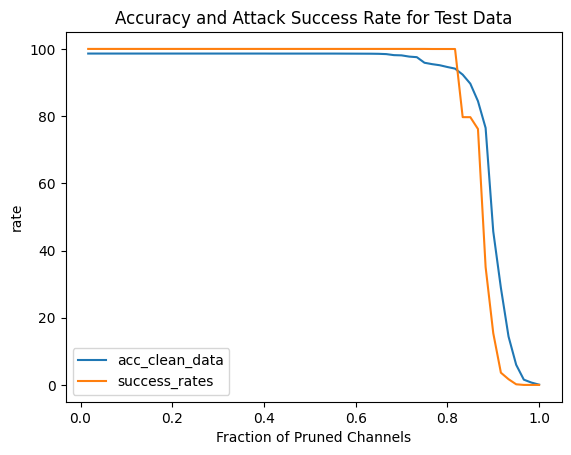

In [ ]:
x_axis = np.arange(1,61)/60
plt.plot(x_axis, acc_clean_datas)
plt.plot(x_axis, success_rates)
plt.legend(['acc_clean_data','success_rates'])
plt.xlabel("Fraction of Pruned Channels")
plt.ylabel("rate")
plt.title("Accuracy and Attack Success Rate for Test Data")

###Test Data Output for each value of X

In [ ]:
#Test Outputs for X = 2%, 4%, 10%

bd_model2_X2 = keras.models.load_model('./models/bd_model2_X2.h5')
bd_model2_X4 = keras.models.load_model('./models/bd_model2_X4.h5')
bd_model2_X10 = keras.models.load_model('./models/bd_model2_X10.h5')

accuracy2, success_rate2 = evalModel(bd_model2_X2)
print(f"\n\nDrop: 2%, Accuracy: {accuracy2}, Success Rate: {success_rate2}\n\n")

accuracy2, success_rate2 = evalModel(bd_model2_X4)
print(f"\n\nDrop: 4%, Accuracy: {accuracy2}, Success Rate: {success_rate2}\n\n")

accuracy2, success_rate2 = evalModel(bd_model2_X10)
print(f"\n\nDrop: 10%, Accuracy: {accuracy2}, Success Rate: {success_rate2}\n\n")

401/401 [==============================] - 12s 29ms/step


Drop: 2%, Accuracy: 96.04053000779423, Success Rate: 100.0


401/401 [==============================] - 9s 23ms/step


Drop: 4%, Accuracy: 94.81683554169913, Success Rate: 99.97661730319564


401/401 [==============================] - 9s 23ms/step


Drop: 10%, Accuracy: 84.67653936087295, Success Rate: 76.1730319563523


